In [11]:
import os
import yaml
import fnmatch
from conda_build.metadata import MetaData
from pprint import pprint
import binstar_client
import matplotlib.pyplot as plt
import copy
%matplotlib inline
import networkx as nx

In [12]:
cli = binstar_client.utils.get_server_api()
packages_on_conda_forge = set([f['full_name'].split('/')[1] for f in cli.show_channel('main', 'conda-forge')['files']])

Using Anaconda Cloud api site https://api.anaconda.org


In [13]:
def sanitize_names(list_of_names):
    list_of_names = [name.split(' ')[0] for name in list_of_names]
    list_of_names = [name for name in list_of_names]# if name not in packages_on_conda_forge]
    return list_of_names

In [14]:
packages = [
    'event-model',
    'lmfit',
    'emcee',
    'doct',
    'boltons',
]

In [15]:
# Get the list of folders to check
# get the tagged stack
path = os.path.join(os.path.expanduser("~"), 'dev', 'conda', 'auto-build-tagged-recipes')
folders = [os.path.join(path, folder) for folder in ['enaml-stack', 
                                                     'nonpy', 
                                                     'py2', 
                                                     'py3', 
                                                     'pyall', 
                                                     os.path.join('sort-of-dev-but-actually-tag', 'py3')]]
# get the scikit-beam stack
folders.append(os.path.join(os.path.expanduser('~'), 'dev', 'conda', 'skbeam-recipes', 'recipes'))

In [16]:
run = {}
build = {}
for path_to_recipes in folders:
    for entry in os.listdir(path_to_recipes):
        if '.yaml' in entry:
            # this is a filename
            continue
        full_path = os.path.join(path_to_recipes, entry)
        meta = MetaData(full_path)
        name = meta.meta['package']['name']
    #         if name in packages_on_conda_forge:
    #             continue
        build[name] = sanitize_names(meta.meta.get('requirements', {}).get('build', []))
        run[name] = sanitize_names(meta.meta.get('requirements', {}).get('run', []))

In [17]:
union = copy.deepcopy(build)
for package, deps in run.items():
    union[package] = set(build.get(package) + run.get(package))

In [18]:
# drop all extra packages that I do not have conda recipes for
for name, items in union.items():
    union[name] = [item for item in items if item in union]

In [19]:
kw = dict(node_size=5, node_color='w', edge_color='b', alpha=0.25)

def make_network(packages_dict):
    G = nx.DiGraph()
    for package, deps in packages_dict.items():
#         print(package)
        for dep in deps:
#             print('\t{}'.format(dep))
            G.add_edge(package, dep)
    return G

In [20]:
run_G = make_network(run)
build_G = make_network(build)
all_G = make_network(union)

In [21]:
it = iter(all_G)

In [22]:
ret = next(it)

In [26]:
G = all_G.copy()
G.reverse()

In [27]:
G.edges()

[('bluesky', 'tifffile'),
 ('bluesky', 'historydict'),
 ('bluesky', 'xray-vision'),
 ('bluesky', 'filestore'),
 ('bluesky', 'event-model'),
 ('bluesky', 'metadatastore'),
 ('bluesky', 'databroker'),
 ('bluesky', 'boltons'),
 ('bluesky', 'super_state_machine'),
 ('bluesky', 'doct'),
 ('pims', 'slicerator'),
 ('epics-base', 'readline'),
 ('git', 'gettext'),
 ('scikit-beam', 'lmfit'),
 ('gobject-introspection', 'cairo-gobject'),
 ('gobject-introspection', 'glib'),
 ('x264', 'yasm'),
 ('h5py', 'hdf5'),
 ('pyepics', 'epics-base'),
 ('eiger-io', 'h5py'),
 ('eiger-io', 'pims'),
 ('eiger-io', 'filestore'),
 ('enaml', 'atom'),
 ('enaml', 'kiwisolver'),
 ('datamuxer', 'tzlocal'),
 ('clint', 'args'),
 ('autoconf', 'm4'),
 ('glib', 'gettext'),
 ('pygobject3', 'cairo-gobject'),
 ('pygobject3', 'gobject-introspection'),
 ('pygobject3', 'py3cairo'),
 ('pygobject3', 'glib'),
 ('py3cairo', 'cairo-gobject'),
 ('py3cairo', 'pkg-config'),
 ('ffmpeg', 'yasm'),
 ('ffmpeg', 'x264'),
 ('pcaspy', 'epics-base')

In [29]:
def print_and_trim(graph):
    nodes = [x for x in (G) if G.out_degree(x) == 0]
    for node in nodes:
        G.remove_node(node)
#     for idx, node in enumerate(nodes):
#         if node not in packages_on_conda_forge:
#             nodes[idx] = node.upper()
    pprint(nodes)

print("Packges in all CAPS are packages that still need to be built")
count = 0
while G.nodes():
    print_and_trim(G)
    count += 1
    if count > 50:
        break

Packges in all CAPS are packages that still need to be built
['tifffile',
 'pyolog',
 'lmfit',
 'gsl',
 'kiwisolver',
 'xray-vision',
 'doct',
 'tzlocal',
 'historydict',
 'mongoquery',
 'pymongo',
 'event-model',
 'ncurses',
 'gettext',
 'yasm',
 'boltons',
 'super_state_machine',
 'atom',
 'fabio',
 'args',
 'hdf5',
 'm4',
 'slicerator']
['pims',
 'git',
 'scikit-beam',
 'x264',
 'h5py',
 'enaml',
 'datamuxer',
 'clint',
 'autoconf',
 'glib',
 'ixstools',
 'hdf5-lz4',
 'readline',
 'metadatastore',
 'amostra',
 'channelarchiver']
['epics-base',
 'ffmpeg',
 'pyxrf',
 'trackpy',
 'chxtools',
 'filestore',
 'automake']
['pyepics', 'eiger-io', 'pcaspy', 'libtool', 'databroker']
['bluesky', 'csxtools', 'suitcase', 'ophyd', 'pkg-config', 'album']
['analysis', 'cairo-gobject']
['gobject-introspection', 'py3cairo', 'collection']
['pygobject3']
['hkl']


In [46]:
G.nodes()

[]

In [102]:
G.edges()

[]

In [53]:
rev = all_G.reverse()
[x for x in rev if rev.out_degree(x) == 0]

['chxtools',
 'pcaspy',
 'hkl',
 'clint',
 'eiger-io',
 'ixstools',
 'pyxrf',
 'trackpy',
 'ffmpeg',
 'suitcase',
 'service_identity',
 'collection',
 'git',
 'csxtools']

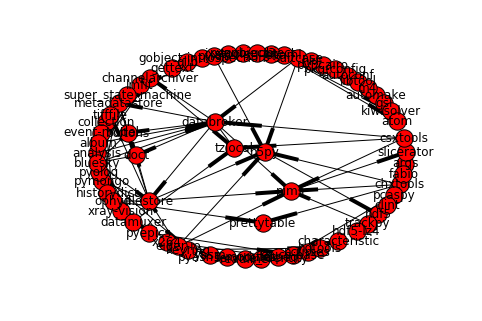

In [33]:
plt.figure()
pos = nx.spring_layout(all_G, k=.2, iterations=200)
nx.draw(all_G, pos, with_labels=True)

In [19]:
def trim_nodes(G, d):
    """Returns a copy of G without the nodes with a degree less than d.
    http://glowingpython.blogspot.com/2012/11/first-steps-with-networx.html
    """
    Gt = G.copy()
    dn = nx.degree(Gt)
    for n in Gt.nodes():
        if dn[n] <= d:
            Gt.remove_node(n)
    return Gt

def plot_deps(G, node, function):
    h = nx.from_dict_of_lists({node: getattr(G, function)(node)})
    nx.draw(h, with_labels=True, **kw)


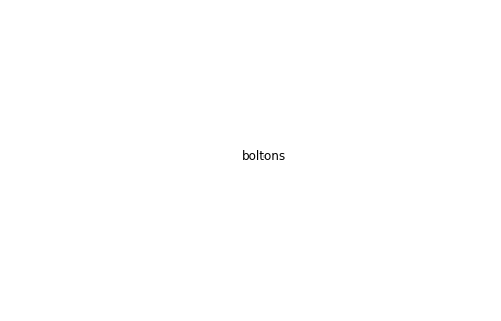

In [36]:
plot_deps(all_G, 'boltons', 'neighbors')

In [37]:
nx.path_graph?

In [38]:
nx.path_graph?

In [39]:
list(nx.strongly_connected_components(all_G))

[{'ncurses'},
 {'readline'},
 {'epics-base'},
 {'pcaspy'},
 {'xray-vision'},
 {'pyepics'},
 {'hdf5'},
 {'slicerator'},
 {'pims'},
 {'atom'},
 {'boltons'},
 {'doct'},
 {'pymongo'},
 {'metadatastore'},
 {'tifffile'},
 {'h5py'},
 {'filestore'},
 {'tzlocal'},
 {'channelarchiver'},
 {'databroker'},
 {'csxtools'},
 {'gettext'},
 {'glib'},
 {'m4'},
 {'autoconf'},
 {'automake'},
 {'libtool'},
 {'pkg-config'},
 {'cairo-gobject'},
 {'py3cairo'},
 {'gobject-introspection'},
 {'pygobject3'},
 {'prettytable'},
 {'ophyd'},
 {'eiger-io'},
 {'fabio'},
 {'hdf5-lz4'},
 {'hgtools'},
 {'keyring'},
 {'yasm'},
 {'x264'},
 {'ffmpeg'},
 {'event-model'},
 {'trackpy'},
 {'kiwisolver'},
 {'enaml'},
 {'pyxrf'},
 {'historydict'},
 {'super_state_machine'},
 {'bluesky'},
 {'args'},
 {'characteristic'},
 {'gsl'},
 {'hkl'},
 {'album'},
 {'suitcase'},
 {'chxtools'},
 {'git'},
 {'pyasn1-modules'},
 {'service_identity'},
 {'pyolog'},
 {'lmfit'},
 {'datamuxer'},
 {'analysis'},
 {'collection'},
 {'clint'},
 {'ixstools'}]

In [40]:
packages_on_conda_forge

{'affine',
 'amqp',
 'antispoofing.utils',
 'antlr',
 'anyjson',
 'appdirs',
 'apptools',
 'arm_pyart',
 'arrow',
 'artview',
 'auditwheel',
 'autoconf',
 'automake',
 'awesome-slugify',
 'babel',
 'backports.shutil_get_terminal_size',
 'basemap',
 'basemap-data-hires',
 'bdw-gc',
 'betamax',
 'betamax-matchers',
 'biggus',
 'billiard',
 'binaryornot',
 'binutils',
 'bison',
 'blinker',
 'bob',
 'bob.ap',
 'bob.bio.base',
 'bob.bio.gmm',
 'bob.bio.spear',
 'bob.blitz',
 'bob.core',
 'bob.db.arface',
 'bob.db.atnt',
 'bob.db.atvskeystroke',
 'bob.db.avspoof',
 'bob.db.banca',
 'bob.db.base',
 'bob.db.biosecure',
 'bob.db.biosecurid.face',
 'bob.db.casia_fasd',
 'bob.db.casme2',
 'bob.db.caspeal',
 'bob.db.frgc',
 'bob.db.gbu',
 'bob.db.iris',
 'bob.db.kboc16',
 'bob.db.lfw',
 'bob.db.livdet2013',
 'bob.db.mnist',
 'bob.db.mobio',
 'bob.db.msu_mfsd_mod',
 'bob.db.multipie',
 'bob.db.nist_sre12',
 'bob.db.replay',
 'bob.db.scface',
 'bob.db.utfvp',
 'bob.db.verification.filelist',
 'bob.d

In [41]:
print("Build Order")
counter = 0
for item in reversed(nx.topological_sort(all_G)):
    if item not in packages_on_conda_forge:
        counter += 1
        print('{:>2}: {}'.format(counter, item))
    else:
        print('##: {}  # Package already on conda-forge'.format(item))

Build Order
##: ncurses  # Package already on conda-forge
##: readline  # Package already on conda-forge
 1: epics-base
 2: pcaspy
 3: xray-vision
 4: pyepics
##: hdf5  # Package already on conda-forge
 5: slicerator
 6: pims
 7: atom
 8: tzlocal
 9: channelarchiver
##: doct  # Package already on conda-forge
10: boltons
11: pymongo
##: h5py  # Package already on conda-forge
##: tifffile  # Package already on conda-forge
12: filestore
13: metadatastore
14: databroker
15: csxtools
##: m4  # Package already on conda-forge
##: autoconf  # Package already on conda-forge
##: automake  # Package already on conda-forge
##: libtool  # Package already on conda-forge
##: pkg-config  # Package already on conda-forge
##: gettext  # Package already on conda-forge
##: glib  # Package already on conda-forge
16: cairo-gobject
17: gobject-introspection
18: py3cairo
19: pygobject3
20: prettytable
21: ophyd
22: eiger-io
23: fabio
24: hdf5-lz4
25: hgtools
26: keyring
##: yasm  # Package already on conda-fo

In [16]:
import uuid
start = order[0]
nodes = [order[0]] # start with first node in topological order
labels = {}
print("edges")
tree = nx.Graph()
idx = 0
while nodes:
    idx += 1
    source = nodes.pop()
    labels[source] = str(idx) + '-' + source
    for target in all_G.neighbors(source):
        if target in tree:
            t = uuid.uuid1() # new unique id
        else:
            t = target
        labels[t] = target
        tree.add_edge(source,t)
        print(source,target,source,t)
        nodes.append(target)

NameError: name 'order' is not defined

In [17]:
%matplotlib inline
plt.figure()
nx.draw(tree, labels=labels)


NameError: name 'tree' is not defined

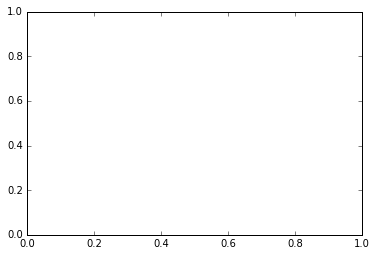

In [80]:
plt.subplots()
nx.traversal.bfs_tree(all_G, 'enaml')